In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 加载 Olivetti Face数据集
olivetti_faces = fetch_olivetti_faces(shuffle=True)
X, y = olivetti_faces.data, olivetti_faces.target

In [5]:
# 转换为PyTorch张量
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [6]:
# 划分训练集和测试集
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, test_size])

In [7]:
# 数据加载器
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# 定义优化的神经网络
class OptimizedFaceNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(OptimizedFaceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),  # 归一化
            activation_fn,
            nn.Dropout(0.3),  # Dropout 正则化
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            activation_fn,
            nn.Dropout(0.3),
            nn.Linear(256, 40)  # 输出层（40 类别）
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# 训练函数
def train_model(model, train_loader, epochs=20, lr=0.01, weight_decay=1e-4):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)  # L2 正则化
    train_hist = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        train_hist.append(avg_loss)

    return train_hist

In [10]:
# 测试函数
def test_acc(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    acc = correct / total * 100
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


In [11]:
# 训练模型
print("\nTraining Optimized Model (BatchNorm + Dropout + L2 Regularization)")
optimized_model = OptimizedFaceNN(activation_fn=nn.ReLU()).to(device)
optimized_hist = train_model(optimized_model, train_loader, epochs=10)


Training Optimized Model (BatchNorm + Dropout + L2 Regularization)
Epoch [1/10], Loss: 3.1880
Epoch [2/10], Loss: 2.0605
Epoch [3/10], Loss: 1.3520
Epoch [4/10], Loss: 0.8363
Epoch [5/10], Loss: 0.5092
Epoch [6/10], Loss: 0.4389
Epoch [7/10], Loss: 0.4031
Epoch [8/10], Loss: 0.2276
Epoch [9/10], Loss: 0.2321
Epoch [10/10], Loss: 0.1654


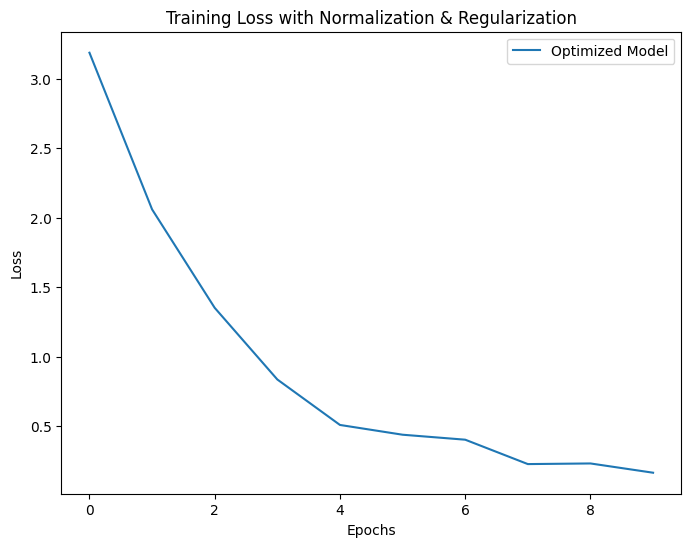

In [12]:
# 画出Loss下降曲线
plt.figure(figsize=(8, 6))
plt.plot(optimized_hist, label="Optimized Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss with Normalization & Regularization")
plt.legend()
plt.show()

In [13]:
# 评估优化后的模型
print("\nEvaluating Optimized Model")
test_acc(test_loader, optimized_model)


Evaluating Optimized Model
Test Accuracy: 98.75%


98.75